In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman, catwoman
from multiprocessing import Pool
import emcee

In [2]:
def calc_H(T, M, R, mm=2.3):
    """ Calculates the approximate scale height of a planet's atmosphere, using the equation
     scale height = kT / mg
    
    Inputs: T = the atmospheric temperature in [K]; M = the planet's mass in [kg]; 
            R = the planet's radius in [m]; mm = mean mass of a molecule in the atmosphere [amu], this is
                   default set to 1 amu = 1 proton mass (for now)
    Outputs: H = the scale height in [m]
    """
    # constants:
    amu = 1.67e-27 # [kg]; atomic mass unit in [kg]
    k = 1.38e-23 # [Joule/K]; Boltzmann constant
    G = 6.674e-11 # [m^3/kg/s^2]; Gravitational constant
    Mjupiter = 1.9e27 # [kg]; mass of Jupiter
    Rjupiter = 69911000.0 # [m]; approx. radius of Jupiter
    # computing the numerator for the scale height equation:
    E_thermal = k*T # [Joule]
    # computing the denominator:
    g = G*M/(R**2) # gravitational acceleration in [m/s^2]
    meanmass = mm*amu
    denominator = meanmass*g # [kg*m/s^2]
    # compute the scale height:
    H = E_thermal / denominator # [meters]
    return H

In [3]:
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

In [6]:
# create a planet
tc = 0. # [day]
per = 3.06785271 # [day]
a = 12.63 # [stellar radii]
inc = 89.02 # [degrees]
phi = 90.
ecc = 0.
w = 90.
r = 0.17137 # [stellar radii]
Rs = 0.605 # [Rsun]
Mp_jup = 0.538 # [jupiter masses]
Teq = 825.0 # [K]
T14 = 2.131 # duration [hours]

# calculate things in physical units
a_meter = a * Rs * Rsun_to_meter
per_seconds = per*day_to_second
Rs_meter = Rs * Rsun_to_meter
Rp_meter = r * Rs_meter
Mp_kg = Mp_jup * Mjup_to_kg

# calculate other things
v_orb = (2.*np.pi*a_meter) / (per_seconds) # [m/s]
H = calc_H(Teq, Mp_kg, Rp_meter, mm=2.3) # [m]

# simulated obs. info from or based on pandexo
t_int = 14.8 # [s] per integration
obs_window_size = (1.0*T14) / 24. # half-duration of whole observation in [day]
t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

print('Planet properties')
print('bulk scale height H = %.2f km'%(H/1000.))

Planet properties
bulk scale height H = 226.16 km


In [7]:
## -- initialize transit model environments
## -- Catwoman:
aparams  = catwoman.TransitParams()
aparams.t0 = tc                          #time of inferior conjuction (in days)
aparams.per = per                         #orbital period (in days)
aparams.rp = r                        #top semi-circle radius (in units of stellar radii)
aparams.rp2 = r                        #bottom semi-circle radius (in units of stellar radii)
aparams.a = a                         #semi-major axis (in units of stellar radii)
aparams.inc = inc                        #orbital inclination (in degrees)
aparams.ecc = ecc                        #eccentricity
aparams.w = w                         #longitude of periastron (in degrees)
aparams.limb_dark = "uniform"          #limbs darkening model
aparams.phi = phi                         #angle of rotation of top semi-circle (in degrees)
asymmodel = catwoman.TransitModel(aparams,t)         #initalises model
#asymLC = asymmodel.light_curve(params)                #calculates light curve

## -- Batman:
uparams  = batman.TransitParams()
uparams.t0 = tc                          #time of inferior conjuction (in days)
uparams.per = per                         #orbital period (in days)
uparams.rp = r                        #top semi-circle radius (in units of stellar radii)
uparams.a = a                         #semi-major axis (in units of stellar radii)
uparams.inc = inc                        #orbital inclination (in degrees)
uparams.ecc = ecc                        #eccentricity
uparams.w = w                         #longitude of periastron (in degrees)
uparams.u = []                   #limb darkening coefficients [u1, u2]
uparams.limb_dark = "uniform"          #limbs darkening model
unifmodel = batman.TransitModel(uparams,t)         #initalises model
#unifLC = unifmodel.light_curve(bparams)                #calculates light curve

## note:
## we assume uniform LD for simplicity. it speeds up the initialization, the fitting, and allows easier estimations
##   of light curve contact points.

In [8]:
# lc_init = unifmodel.light_curve(uparams)
# plt.plot(t, lc_init)
# plt.show()

In [9]:
def logLikelihood(ydata, yerr, modely):
    """ Computes the Bayesian likelihood of a model, given the data (or is it the other way around?)
    Inputs: ydata = your data, yerr= uncertainties on your data, modely = same size array of the model's values
    outputs: ln( the likelihood )
    """
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    return lnL

def lnPosterior(tc_fitting, t, y, yerr, adj_rprs, inittransitenv):
    ## computes the log Posterior of model, given data
    ## we are fitting data (generated from an asymmetric-limb model) using
    ##   a uniform-limb transit model, and fitting for the tc
    ## Major input is the tc parameter, and the uniform-limb rprs. Other transit params. are fixed to their true values
    #
    # Take step's tc and gen. a uniform-limb model, using fixed true transit params.
    fitparams  = batman.TransitParams()
    fitparams.t0 = tc_fitting                          #time of inferior conjuction (in days)
    fitparams.per = per                         #orbital period (in days)
    fitparams.rp = adj_rprs                        #top semi-circle radius (in units of stellar radii)
    fitparams.a = a                         #semi-major axis (in units of stellar radii)
    fitparams.inc = inc                        #orbital inclination (in degrees)
    fitparams.ecc = ecc                        #eccentricity
    fitparams.w = w                         #longitude of periastron (in degrees)
    fitparams.u = []                   #limb darkening coefficients [u1, u2]
    fitparams.limb_dark = "uniform"          #limbs darkening mode
    fit_LC = inittransitenv.light_curve(fitparams)                #calculates light curve
    # calculate likelihood of this model, given input data
    lnL = logLikelihood(y, yerr, fit_LC)
    # we ignore priors, so this likelihood is it
    return lnL

In [10]:
## -- Run the numerical simulation
## -- Goal: for a range of input, injected limb asymmetries ... record how the best-fit
##       time of conjunctions deviate from the true value when fitting the data using a 
##       uniform-limb transit model
## -- Things to save:
##      - best-fit tc and uncertainties
#       - the "true" light curve (i.e. what data was initialized off of)
#       - the "best-fit" light curve (i.e. the uniform-limb model with the best-fit, deviated tc)

# Define N values to test (delta R = N * scale height)
Nvals = np.linspace(0., 5.0, 10) 
# Set up arrays of to-be-saved quantities
dt_fits = np.zeros(len(Nvals))    # best-fit tc - true tc, in [s]
dt_pluserrs = np.zeros(len(Nvals))
dt_minuserrs = np.zeros(len(Nvals))
dt_fiterrs = np.zeros(len(Nvals)) # uncertainty on above (i.e. uncertainty on best-fit tc), in [s]
dt_calcs = np.zeros(len(Nvals))   # an estimate of dt
true_lightcurves = np.zeros((len(Nvals), len(t)))
bestfit_lightcurves = np.zeros((len(Nvals), len(t)))

# Run the simulation ....
for iN, N in enumerate(Nvals):
    print('='*50)
    print('Step %d of %d'%(iN+1, len(Nvals)))
    print('testing N = %.2f'%(N))
 
    # set the evening limb to some pre-defined value, that doesn't change
    Rp_evening_meter = Rp_meter # true evening-limb radius in [m]
    rprs_evening = Rp_evening_meter / Rs_meter
    # define limb extension
    dR_meter = N * H # difference btwn. evening- and morning-limb radii in [m]
    # extend morning by this amount
    Rp_morning_meter = Rp_evening_meter + dR_meter # true morning-limb radius in [m]
    rprs_morning = Rp_morning_meter / Rs_meter
    # and calculate Rp based on analagous homogeneous transit depth
    #Rp_uniform_m = np.sqrt((Rp_evening_m**2) + (Rp_evening_m * dR_m) + (dR_m**2)) # in [m]
    Rp_uniform_meter = np.sqrt(0.5*(Rp_evening_meter**2 + Rp_morning_meter**2))
    rprs_uniform = Rp_uniform_meter / Rs_meter

    print('dR = %.1f m (%.1f scale heights, %.2f percent of Rp)'%(dR_meter, N, (100.*dR_meter/Rp_evening_meter)))
    print('Evening limb radius = %.1f m'%(Rp_evening_meter))
    print('Morning limb radius = %.1f m'%(Rp_morning_meter))
    print('Analogous uniform limb radius = %.1f m'%(Rp_uniform_meter))
    print('     = %.4f x evening limb '%(Rp_uniform_meter / Rp_evening_meter))
    print('     = %.4f x morning limb '%(Rp_uniform_meter / Rp_morning_meter))

    # compute corresponding rp/rs values, using pre-defined stellar radius
    dr = dR_meter / Rs_meter # difference btwn. evening- and morning-limb Rp/Rs
    #r_evening = Rp_evening_m / Rs_meter # true evening-limb Rp/Rs
    #r_morning = Rp_morning_m / Rs_meter # true morning-limb Rp/Rs
    #r_uniform = Rp_uniform_m / Rs_meter # "equivalent" uniform-limb Rp/Rs (one that preserves total depth)
    print('dr = %.4f '%(dr))
    print('Evening limb Rp/Rs = %.4f'%(rprs_evening))
    print('Morning limb Rp/Rs = %.4f'%(rprs_morning))
    print('Analogous uniform limb Rp/Rs = %.4f'%(rprs_uniform))
    print('     = %.4f x evening limb '%(rprs_uniform / rprs_evening))
    print('     = %.4f x morning limb '%(rprs_uniform / rprs_morning))

    # calculate expected shift in transit midpoint via method 1
    #dt_numerator1 = (Rp_morning_m + Rp_evening_m) - 2.*Rp_uniform_m
    #dt_expected1_sec = (dt_numerator1) / (2.*v_orb) # [s]
    #dt_expected1_day = dt_expected1_sec / day_to_second 
    # calculate expected shift via method 2
    d_pathlength = - dR_meter
    dt_expected2_sec = (d_pathlength) / (v_orb)

    #print('Expected shift (method 1) = %.2f seconds'%(dt_expected1_sec))
    print('Expected shift (method 2) = %.2f seconds'%(dt_expected2_sec))
    
    # update transit model parameters
    # asymmetric transit:
    #    doing them from scratch to prevent aliasing errors
    # For the "true" asymmetric planet
    testparams_a  = catwoman.TransitParams()
    testparams_a.t0 = tc            #time of inferior conjuction (in days)
    testparams_a.per = per            #orbital period (in days)
    testparams_a.rp = rprs_evening    #top semi-circle radius (in units of stellar radii)
    testparams_a.rp2 = rprs_morning   #bottom semi-circle radius (in units of stellar radii)
    testparams_a.phi = phi          #angle of rotation of top semi-circle (in degrees)
    testparams_a.a = a            #semi-major axis (in units of stellar radii)
    testparams_a.inc = inc          # orbital inclination (in degrees)
    testparams_a.ecc = ecc          #eccentricity
    testparams_a.w = w              #longitude of periastron (in degrees)
    testparams_a.limb_dark = "uniform"  #limbs darkening model
    # analogous uniform transit:
    #uparams.rp = r_uniform # equivalent depth Rp/Rs

    # generate the "true" light curve to use for data initialization
    lc_asym = asymmodel.light_curve(testparams_a)
    #lc_unif = unifmodel.light_curve(uparams)
    # save this "true" light curve
    true_lightcurves[iN,:] = np.copy(lc_asym)

    # generate synthetic data around asymmetric light curve
    y_sim, yerr_sim = np.zeros(len(lc_asym)), np.zeros(len(lc_asym))
    scatter = 200. / 1.e6 # LC scatter in [ppm] (converted to decimal)
    for i, time in enumerate(t):
        y_sim[i] = lc_asym[i] + np.random.normal(loc=0., scale=scatter) # injects uncorrelated Gaussian noise
        yerr_sim = scatter # assume uncertainty = scatter
        
    # set up the MCMC...
    # initial tc = the truth, with an initialization ball of ~seconds
    tc_init = tc
    tc_initerr = (1.0) /24./24./60.

    Ndim = 1 # N parameters = 1 -- just tc
    Nwalkers = 5 # N mcmc walkers
    pos = np.zeros((Nwalkers, Ndim)) # set up initial walker positions
    pos[:,0] = tc_init + np.random.normal(0., tc_initerr, Nwalkers)

    Nburn = 500 # burn-in steps
    Nsteps = 5000 + Nburn # steps to run mcmc sampling
    # run the MCMC ...
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(Nwalkers, Ndim, lnPosterior, pool=pool,
                                       args=(t, y_sim, yerr_sim, rprs_uniform, unifmodel))
        sampler.run_mcmc(pos, Nsteps, progress=True)
    # get the walker positions
    samples = sampler.get_chain(discard=Nburn)
    flatsamples = sampler.get_chain(discard=Nburn, flat=True)
    
    # compute best-fit tc, with the uniform-limb model
    tc_bestfit = np.median(flatsamples[:,0]) # "best-fit", median of posterior
    tc_pluserr = np.percentile(flatsamples[:,0], 84) - tc_bestfit # the upper 1-sigma error bar, based on 84th percentile of posterior
    tc_minuserr = tc_bestfit - np.percentile(flatsamples[:,0], 16) # the lower 1-sigma error bar, based on 16th percentile of posterior
    tc_besterr = np.mean((tc_pluserr, tc_minuserr)) # the "average" error bar for simplicity, assuming the posterior is a Gaussian
    # determine deviation between best-fit tc and true tc
    dt_bestfit_sec = (tc_bestfit - tc)*day_to_second
    dt_besterr_sec = tc_besterr*day_to_second
    # save values
    dt_fits[iN] = dt_bestfit_sec
    dt_pluserrs[iN] = (tc_pluserr*day_to_second)
    dt_minuserrs[iN] = (tc_minuserr*day_to_second)
    dt_fiterrs[iN] = dt_besterr_sec
    dt_calcs[iN] = dt_expected2_sec
    
    # generate "best-fit" light curve
    ## -- Batman:
    ufitparams  = batman.TransitParams()
    ufitparams.t0 = tc_bestfit                          #time of inferior conjuction (in days)
    ufitparams.per = per                         #orbital period (in days)
    ufitparams.rp = rprs_uniform                        #top semi-circle radius (in units of stellar radii)
    ufitparams.a = a                         #semi-major axis (in units of stellar radii)
    ufitparams.inc = inc                        #orbital inclination (in degrees)
    ufitparams.ecc = ecc                        #eccentricity
    ufitparams.w = w                         #longitude of periastron (in degrees)
    ufitparams.u = []                   #limb darkening coefficients [u1, u2]
    ufitparams.limb_dark = "uniform"          #limbs darkening model
    bf_unifmodel = batman.TransitModel(ufitparams,t)         #initalises model
    bf_unifLC = bf_unifmodel.light_curve(ufitparams)
    bestfit_lightcurves[iN,:] = bf_unifLC

Step 1 of 10
testing N = 0.00
dR = 0.0 m (0.0 scale heights, 0.00 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72129375.9 m
Analogous uniform limb radius = 72129375.9 m
     = 1.0000 x evening limb 
     = 1.0000 x morning limb 
dr = 0.0000 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1714
Analogous uniform limb Rp/Rs = 0.1714
     = 1.0000 x evening limb 
     = 1.0000 x morning limb 
Expected shift (method 2) = -0.00 seconds


100%|██████████| 5500/5500 [00:06<00:00, 835.64it/s]


Step 2 of 10
testing N = 0.56
dR = 125645.6 m (0.6 scale heights, 0.17 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72255021.5 m
Analogous uniform limb radius = 72192226.1 m
     = 1.0009 x evening limb 
     = 0.9991 x morning limb 
dr = 0.0003 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1717
Analogous uniform limb Rp/Rs = 0.1715
     = 1.0009 x evening limb 
     = 0.9991 x morning limb 
Expected shift (method 2) = -1.00 seconds


100%|██████████| 5500/5500 [00:06<00:00, 832.94it/s]

Step 3 of 10
testing N = 1.11
dR = 251291.1 m (1.1 scale heights, 0.35 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72380667.1 m
Analogous uniform limb radius = 72255130.7 m
     = 1.0017 x evening limb 
     = 0.9983 x morning limb 
dr = 0.0006 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1720
Analogous uniform limb Rp/Rs = 0.1717
     = 1.0017 x evening limb 
     = 0.9983 x morning limb 
Expected shift (method 2) = -1.99 seconds



100%|██████████| 5500/5500 [00:06<00:00, 841.03it/s]

Step 4 of 10
testing N = 1.67
dR = 376936.7 m (1.7 scale heights, 0.52 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72506312.6 m
Analogous uniform limb radius = 72318089.9 m
     = 1.0026 x evening limb 
     = 0.9974 x morning limb 
dr = 0.0009 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1723
Analogous uniform limb Rp/Rs = 0.1718
     = 1.0026 x evening limb 
     = 0.9974 x morning limb 
Expected shift (method 2) = -2.99 seconds



100%|██████████| 5500/5500 [00:06<00:00, 844.77it/s]

Step 5 of 10
testing N = 2.22
dR = 502582.2 m (2.2 scale heights, 0.70 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72631958.2 m
Analogous uniform limb radius = 72381103.3 m
     = 1.0035 x evening limb 
     = 0.9965 x morning limb 
dr = 0.0012 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1726
Analogous uniform limb Rp/Rs = 0.1720
     = 1.0035 x evening limb 
     = 0.9965 x morning limb 
Expected shift (method 2) = -3.99 seconds



100%|██████████| 5500/5500 [00:06<00:00, 832.32it/s]


Step 6 of 10
testing N = 2.78
dR = 628227.8 m (2.8 scale heights, 0.87 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72757603.7 m
Analogous uniform limb radius = 72444170.8 m
     = 1.0044 x evening limb 
     = 0.9957 x morning limb 
dr = 0.0015 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1729
Analogous uniform limb Rp/Rs = 0.1721
     = 1.0044 x evening limb 
     = 0.9957 x morning limb 
Expected shift (method 2) = -4.99 seconds


100%|██████████| 5500/5500 [00:06<00:00, 830.53it/s]

Step 7 of 10
testing N = 3.33
dR = 753873.3 m (3.3 scale heights, 1.05 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 72883249.3 m
Analogous uniform limb radius = 72507292.4 m
     = 1.0052 x evening limb 
     = 0.9948 x morning limb 
dr = 0.0018 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1732
Analogous uniform limb Rp/Rs = 0.1723
     = 1.0052 x evening limb 
     = 0.9948 x morning limb 
Expected shift (method 2) = -5.98 seconds



100%|██████████| 5500/5500 [00:06<00:00, 815.20it/s]


Step 8 of 10
testing N = 3.89
dR = 879518.9 m (3.9 scale heights, 1.22 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 73008894.8 m
Analogous uniform limb radius = 72570467.8 m
     = 1.0061 x evening limb 
     = 0.9940 x morning limb 
dr = 0.0021 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1735
Analogous uniform limb Rp/Rs = 0.1724
     = 1.0061 x evening limb 
     = 0.9940 x morning limb 
Expected shift (method 2) = -6.98 seconds


100%|██████████| 5500/5500 [00:06<00:00, 825.74it/s]

Step 9 of 10
testing N = 4.44
dR = 1005164.4 m (4.4 scale heights, 1.39 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 73134540.4 m
Analogous uniform limb radius = 72633697.0 m
     = 1.0070 x evening limb 
     = 0.9932 x morning limb 
dr = 0.0024 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1738
Analogous uniform limb Rp/Rs = 0.1726
     = 1.0070 x evening limb 
     = 0.9932 x morning limb 
Expected shift (method 2) = -7.98 seconds



100%|██████████| 5500/5500 [00:06<00:00, 812.40it/s]

Step 10 of 10
testing N = 5.00
dR = 1130810.0 m (5.0 scale heights, 1.57 percent of Rp)
Evening limb radius = 72129375.9 m
Morning limb radius = 73260185.9 m
Analogous uniform limb radius = 72696979.7 m
     = 1.0079 x evening limb 
     = 0.9923 x morning limb 
dr = 0.0027 
Evening limb Rp/Rs = 0.1714
Morning limb Rp/Rs = 0.1741
Analogous uniform limb Rp/Rs = 0.1727
     = 1.0079 x evening limb 
     = 0.9923 x morning limb 
Expected shift (method 2) = -8.97 seconds



100%|██████████| 5500/5500 [00:06<00:00, 802.17it/s]


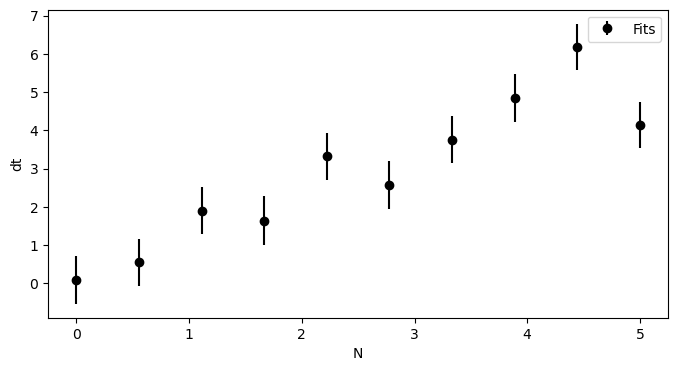

In [11]:
## -- check timing bias
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(Nvals, abs(dt_fits), dt_fiterrs, ls='None', c='black', marker='o', label='Fits')
#
#ax.plot(Nvals, abs(0.5*dt_calcs), c='blue', label='Analytic')
#ax.plot(Nvals, (5./4.)*abs(0.5*dt_calcs), c='blue', ls='--', label='Analytic * 5/4')
#ax.plot(Nvals, test, c='blue', label='1.35*Analytic')
ax.set(xlabel='N', ylabel='dt')
ax.legend(loc='best')
plt.show()

In [12]:
save_results = True
if save_results:
    filename = './newresults_realcadence_200ppmnoise_wasp80b_uniformLD.npz'
    np.savez(filename,
            Nvals=Nvals, Hval=H, dt_fits=dt_fits, dt_fiterrs=dt_fiterrs, 
            dt_pluserrs=dt_pluserrs, dt_minuserrs=dt_minuserrs,
            true_lightcurves=true_lightcurves, bestfit_lightcurves=bestfit_lightcurves,
            dt_cals=dt_calcs,
            time_axis=t)